# Libraries
Below we import the libraries we will use later and download bla bla

In [85]:
import os
import nltk
import string
import re
import gensim
import inflect
import optuna
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from typing import Optional,Tuple,Literal,Union
from functools import partial

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.metrics import (
    calinski_harabasz_score, normalized_mutual_info_score,
    v_measure_score, fowlkes_mallows_score,
    homogeneity_score, completeness_score,
    silhouette_score, davies_bouldin_score, adjusted_rand_score
)

from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer # another 2 kinds of Stemmer (Snowball and Lancaster)

from gensim.models import Word2Vec

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /home/leonardo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/leonardo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/leonardo/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/leonardo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/leonardo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/leonardo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

# Data, Regex and Functions
Below we do the following:
- Import the data
- Compile RegeX patterns
- create inflect engine to convert numbers to words
- import the Porter Stemmer (to explain why we do not use Lancaster or Snowball) and Lemmatizer 

In [8]:
df = pd.read_csv('dataset/imdb_text2vec.csv')
# regex
YEAR_RE = re.compile(r"\b((?:18|19|20)\d{2}|[1-9]0['’]?s)\b")         
RATING_RE = re.compile(r'\b\d*(?:\.\d+)?\s*/\s*(?:5|10|100)\b')
NUM_RE = re.compile(r'\b\d+(\.\d+)?\b')
SPACES_RE = re.compile(r'\s*([?!.,]+(?:\s+[?!.,]+)*)\s*') #ciao,bella -> ciao, bella
HTML_RE = re.compile(r"<(?:\"[^\"]*\"['\"]*|'[^']*'['\"]*|[^'\">])+>")
# other
p = inflect.engine()
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

df.columns

Index(['id', 'sentiment', 'review'], dtype='object')

# Functions
Here we create the core functions for our work, these are inspired from some aricles of Geek for Geeks - references at the bottom of the file. Some of these functions will be explained later as we use them, but for further details read their description. Kind of functions:
- convert numbers
- remove punctuations
- fix html and spaces
- remove stopwords
- lematization, stemming, POS tagging
- processing df: we gather our selected cleaning procedure in a unique function


In [ ]:

def _convert_nums(text:str,
        mx_splt_num:int = 1) -> str:

    '''
    We can also convert the numbers into words.
    This can be done by using the inflect library.
    
    mx_num_split, we do not want conversions, like 100-> one hundred,
    so we set the maximum number of words
    '''

    # assign <RATING>
    text = re.sub(RATING_RE,'<RATING>',text)
    #assign <YEAR> for 80s,90's, 1990...
    text = re.sub(YEAR_RE,'<YEAR>',text)

    # convert numbers below a threshold to string
    temp_str = text.split()
    new_string = []

    for w in temp_str:

        n2w = p.number_to_words(w) # if not a number(e.g. dog) it returns 'zero'
        cond = (w.isdigit()) and (len(n2w.split())<=mx_splt_num)
        
        to_append = n2w if cond else w
        new_string.append(to_append)

    # Other Numbers become <NUM>
    text = re.sub(NUM_RE,'<NUM>',' '.join(new_string))

    return text


def _remove_simple(text:str) -> str:

    """Does simple cleaning of HTML, and no spaces after commas"""

    # remove html patterns
  
    text = re.sub(HTML_RE, '', text)

    # remove issues like: ciao,bella
    text = SPACES_RE.sub(lambda x: "{} ".format(x.group(1).replace(" ", "")), text)

    return text


def _remove_punct(text:str,
                  to_keep:Optional[str] = "") -> str:
    '''
    We remove punctuations so that we don't have different forms of the same word.

    '''
    punctuation = ''.join(ch for ch in string.punctuation if ch not in to_keep)
    translator = str.maketrans('', '', punctuation)

    return text.translate(translator)


def _remove_stopwords(text:str,
                      other_stopwords:list[str]|str = None,
                      to_keep:list[str]|str = None,
                      lst_output:bool=False) -> list[str]:

    '''
    Stopwords are words that do not contribute much to the meaning of a sentence
    hence they can be removed. The NLTK library has a set of 
    stopwords and we can use these to remove stopwords from our text.     
    '''
    
    stop_words = set(stopwords.words("english"))

    if other_stopwords: stop_words.update(set(other_stopwords))
    if to_keep: stop_words.discard(set(to_keep))

    word_tokens = word_tokenize(text)
    clean = [w for w in word_tokens if not w.lower() in stop_words]
    return clean if lst_output else ' '.join(clean)

    
def _stem_words(text:list[str]|str,
                lst_output:bool=True) -> list[str]:
    '''
    Stemming is the process of getting the root form of a word.
    Stem or root is the part to which affixes like -ed, -ize, -de, -s, etc are added.
    The stem of a word is created by removing the prefix or suffix of a word.
    
    '''
    word_tokens = text if isinstance(text,list) else word_tokenize(text)
    stems = [stemmer.stem(word) for word in word_tokens]
    return stems if lst_output else ' '.join(stems)


def _lemma_words(text:str,
                 lst_output:bool=True) -> list[str]:
    '''
    Lemmatization is an NLP technique that reduces a word to its root form.
    This can be helpful for tasks such as text analysis and search as it
    allows us to compare words that are related but have different forms.

    combines pos_tagging with wordnet_pos for better lemma
    
    '''

    iterable = _pos_tagging(text)

    lemmas = [lemmatizer.lemmatize(w,_get_wordnet_pos(p)) for w, p in iterable]

    return lemmas if lst_output else ' '.join(lemmas)


def _pos_tagging(text):
    '''
    POS tagging is the process of assigning each word in a sentence its grammatical category,
    such as noun, verb, adjective or adverb. It helps machines understand the structure 
    and meaning of text, enabling tasks like parsing, information extraction and text analysis.

    NNP: Proper noun
    NN: Noun (singular)
    VBZ: Verb (3rd person singular)
    CC: Conjunction


    '''
    word_tokens = word_tokenize(text)
    return pos_tag(word_tokens)


def _get_wordnet_pos(treebank_tag):

    '''
    Get wordnet positioning: https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python
    '''

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  #default


def preprocess_df(df:pd.DataFrame
                  ) -> pd.DataFrame:
    '''
    Perform cleaning on reviews:
    https://www.geeksforgeeks.org/machine-learning/text-preprocessing-in-python-set-1/

    '''
    # 0.  x.lower().split() -> lower case and remove extra spaces,
    # also number conversion (see above)
    df['num_clean'] = df['review'].apply(lambda x: _convert_nums(" ".join(x.lower().split())))

    # 1 remove html and ciao,bella->ciao, bella
    df['first_l_cl'] = df['num_clean'].apply(lambda x: _remove_simple(x))

    # 2 remove punctuation
    df['sec_l_cl'] = df['first_l_cl'].apply(lambda x: _remove_punct(x))

    # 3 remove stopwords 
    df['no_stopw'] = df['sec_l_cl'].apply(lambda x: _remove_stopwords(x,lst_output= False))

    # 4a lemmas 
    df['lemmas'] = df['no_stopw'].apply(lambda x: _lemma_words(x, lst_output=True))

    # 5a stemming
    df['stem'] = df['no_stopw'].apply(lambda x: _stem_words(x, lst_output=True))

    return df

    

# Dataset clearning steps
Our function preprocess_df, picks up the main cleaning steps in the following order
1. We set to lower case and remove unnecessary blanks
2. we convert numbers to strings if below 100, ratings (e.g. 7.5/10,60/100) become < RATING > while expression of years (e.g. 80s/2000) become < YEAR >, while other numbers becoome < NUM > so that we do not loose information
3. Upon taking care of numbers, we do a simple clearning to fix some issues: such as html words (e.g. <\b>) and to add forgotten blanks after commas.
4. We can now remove the whole punctuations
5. We remove stopwords
6. we can apply lemmatisation or stemming

In [10]:
# it takes a bit to process, but i m too lazy to optimize 

cleaned = preprocess_df(df)

cleaned.head(15)

,id,sentiment,review,num_clean,first_l_cl,sec_l_cl,no_stopw,lemmas,stem
0,5814_8,1,With all this stuff going down at the moment w...,with all this stuff going down at the moment w...,with all this stuff going down at the moment w...,with all this stuff going down at the moment w...,stuff going moment mj ive started listening mu...,"[stuff, go, moment, mj, ive, start, listen, mu...","[stuff, go, moment, mj, ive, start, listen, mu..."
1,2381_9,1,"\""The Classic War of the Worlds\"" by Timothy H...","\""the classic war of the worlds\"" by timothy h...","\""the classic war of the worlds\"" by timothy h...",the classic war of the worlds by timothy hines...,classic war worlds timothy hines entertaining ...,"[classic, war, world, timothy, hines, entertai...","[classic, war, world, timothi, hine, entertain..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,the film starts with a manager (nicholas bell)...,the film starts with a manager (nicholas bell)...,the film starts with a manager nicholas bell g...,film starts manager nicholas bell giving welco...,"[film, start, manager, nicholas, bell, give, w...","[film, start, manag, nichola, bell, give, welc..."
3,3630_4,0,It must be assumed that those who praised this...,it must be assumed that those who praised this...,it must be assumed that those who praised this...,it must be assumed that those who praised this...,must assumed praised film greatest filmed oper...,"[must, assume, praised, film, great, film, ope...","[must, assum, prais, film, greatest, film, ope..."
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,superbly trashy and wondrously unpretentious <...,superbly trashy and wondrously unpretentious ...,superbly trashy and wondrously unpretentious ...,superbly trashy wondrously unpretentious explo...,"[superbly, trashy, wondrously, unpretentious, ...","[superbl, trashi, wondrous, unpretenti, exploi..."
5,8196_8,1,I dont know why people think this is such a ba...,i dont know why people think this is such a ba...,i dont know why people think this is such a ba...,i dont know why people think this is such a ba...,dont know people think bad movie got pretty go...,"[dont, know, people, think, bad, movie, get, p...","[dont, know, peopl, think, bad, movi, got, pre..."
6,7166_2,0,"This movie could have been very good, but come...","this movie could have been very good, but come...","this movie could have been very good, but come...",this movie could have been very good but comes...,movie could good comes way short cheesy specia...,"[movie, could, good, come, way, short, cheesy,...","[movi, could, good, come, way, short, cheesi, ..."
7,10633_1,0,I watched this video at a friend's house. I'm ...,i watched this video at a friend's house. i'm ...,i watched this video at a friend's house. i'm ...,i watched this video at a friends house im gla...,watched video friends house im glad waste mone...,"[watch, video, friend, house, im, glad, waste,...","[watch, video, friend, hous, im, glad, wast, m..."
8,319_1,0,"A friend of mine bought this film for 1, and e...","a friend of mine bought this film for <NUM>, a...","a friend of mine bought this film for, and eve...",a friend of mine bought this film for and even...,friend mine bought film even grossly overprice...,"[friend, mine, buy, film, even, grossly, overp...","[friend, mine, bought, film, even, grossli, ov..."
9,8713_10,1,<br /><br />This movie is full of references. ...,<br /><br />this movie is full of references. ...,"this movie is full of references. like \""mad m...",this movie is full of references like mad max ...,movie full references like mad max ii wild one...,"[movie, full, reference, like, mad, max, ii, w...","[movi, full, refer, like, mad, max, ii, wild, ..."


# Analysis

In [11]:
# TR: word2vec TF-IDF: https://www.geeksforgeeks.org/python/python-word-embedding-using-word2vec/

# Models Setup 
LS: doing some random stuff

In [ ]:

def _clusterSelection(model:Literal['SKM','GMM','SPEC'],
                      k:int = 5,
                      rs_seed:int=1
                      ) -> Union[KMeans,GaussianMixture,SpectralClustering]:
    """
    Return the clustering model object and its Optuna parameter space.
    model: one of ['SKM', 'GMM', 'SPEC']
    """
    match model:
        case 'SKM':  # Spherical K-Means (use normalized TF-IDF + cosine)
            ml_model = KMeans(
                n_clusters=k,  # updated inside Optuna trial
                random_state=rs_seed,
                init='k-means++',
                n_init='auto'
            )
        case 'GMM':
            ml_model = GaussianMixture(
                n_components=k,
                covariance_type='diag',
                random_state=rs_seed
            )

        case 'SPEC':
            ml_model = SpectralClustering(
                n_clusters=k,
                affinity='nearest_neighbors', # or rbf
                assign_labels='kmeans', # or discritize
                random_state=rs_seed 
            )

    return ml_model

def _modelPreprocessing(df:pd.DataFrame,
                        model:str,
                        svd:bool = False,
                        svd_comp:int=300,
                        sd:int=1) -> Tuple[np.ndarray, np.ndarray]:
    """
    TO FIX ACCORDING TO WHAT WE DO IN THE ANLYSIS STEP
    """
    labels = df['sentiment'].to_numpy()

    in_text = df['lemmas'].apply(
        lambda x: " ".join(x) if isinstance(x, list) 
        else x)
    
    vectorizer = TfidfVectorizer(
            max_features=5000,
            stop_words='english',
            sublinear_tf=True,
            min_df=5,
            max_df=0.7
        )
    tf_idf = vectorizer.fit_transform(in_text)

    match model:
        case 'SKM':
            vals = normalize(tf_idf)
        case 'GMM' | 'SPEC':
            if svd:
                svd = TruncatedSVD(n_components=svd_comp, random_state=sd)
                vals = svd.fit_transform(tf_idf).astype(np.float32)
            else:
                vals = tf_idf.toarray()
            
    return vals, labels


In [88]:
def TestClusters(df:pd.DataFrame,
                 models:list[str] = ['SKM', 'GMM', 'SPEC'],
                 sd:int = 1
                 ) -> pd.DataFrame:
    
    """
    Test Models three selected models for 5 to 10 number of clusters.
    Return a pandas df with outputs
    """

    res_dct = {
        'model':[],
        'n_clusters':[],
        'sil':[],
        'dbi':[],
        'ari':[],
        'chi':[],
        'nmi': [],
        'vmeasure': [],
        'fmi': [],}

    for model in models:
        print(f'Working on {model} model!\n')
        vals, labels = _modelPreprocessing(df,model)
        for n_clusters in range(5,11,1):
            ml_model = _clusterSelection(model,n_clusters)
            preds = ml_model.fit_predict(vals)

            vals_dense = vals.toarray() if hasattr(vals, "toarray") else vals

            res_dct['model'].append(model)
            res_dct['n_clusters'].append(n_clusters)
            res_dct['sil'].append(silhouette_score(vals, preds, metric='cosine',random_state=sd)) #internal
            res_dct['dbi'].append(davies_bouldin_score(vals_dense, preds)) #internal
            res_dct['ari'].append(adjusted_rand_score(labels, preds)) #external

            res_dct['chi'].append(calinski_harabasz_score(vals_dense, preds)) #internal
            res_dct['nmi'].append(normalized_mutual_info_score(labels, preds)) # external
            res_dct['vmeasure'].append(v_measure_score(labels, preds)) #external
            res_dct['fmi'].append(fowlkes_mallows_score(labels, preds)) #external 

    return pd.DataFrame(res_dct)


def comparison_charts(df:pd.DataFrame,
                      indicators: list[str]=['sil','dbi','chi','ari','nmi','vmeasure'] #only most relevant
                      )->None:

    """
    Create a 2x3 grid of subplots comparing models across validation indicators.
    Each subplot shows scores for all models as a function of n_clusters.
    The metrics to plot (3 internal + 3 external)
    """


    sns.set_context("notebook")
    sns.set_style("white")

    fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=True)
    axes = axes.flatten()

    model_palette = sns.color_palette("deep", n_colors=df['model'].nunique())
    hue_order = sorted(df['model'].unique())

    handles, labels = None, None # init

    for i, ind in enumerate(indicators):
        ax = axes[i]

        if ind not in df.columns:
            ax.set_visible(False)
            continue

        plot = sns.lineplot(
            data=df,
            x='n_clusters',
            y=ind,
            hue='model',
            hue_order=hue_order,
            marker='o',
            linewidth=1.3,
            ax=ax,
            palette=model_palette
        )

        if handles is None:
            handles, labels = plot.get_legend_handles_labels()

        leg = ax.get_legend()
        if leg:
            leg.remove()

        ax.set_title(ind.upper(), fontsize=9, weight='bold', pad=3)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.tick_params(labelsize=8)
        ax.spines[['top','right']].set_visible(False)
        ax.grid(False)

        if ind == 'dbi':
            ax.invert_yaxis()

    if handles and labels:
        fig.legend(
            handles, labels,
            loc='upper center',
            ncol=len(hue_order),
            frameon=False,
            fontsize=9,
            handlelength=2.0
        )

    plt.subplots_adjust(wspace=0.3, hspace=0.25, top=0.88)
    plt.savefig('charts/indicators.png')
    plt.show()

In [90]:
# testing codes

comparisons = TestClusters(cleaned)

Working on SKM model!

Working on GMM model!



UnboundLocalError: cannot access local variable 'vals' where it is not associated with a value

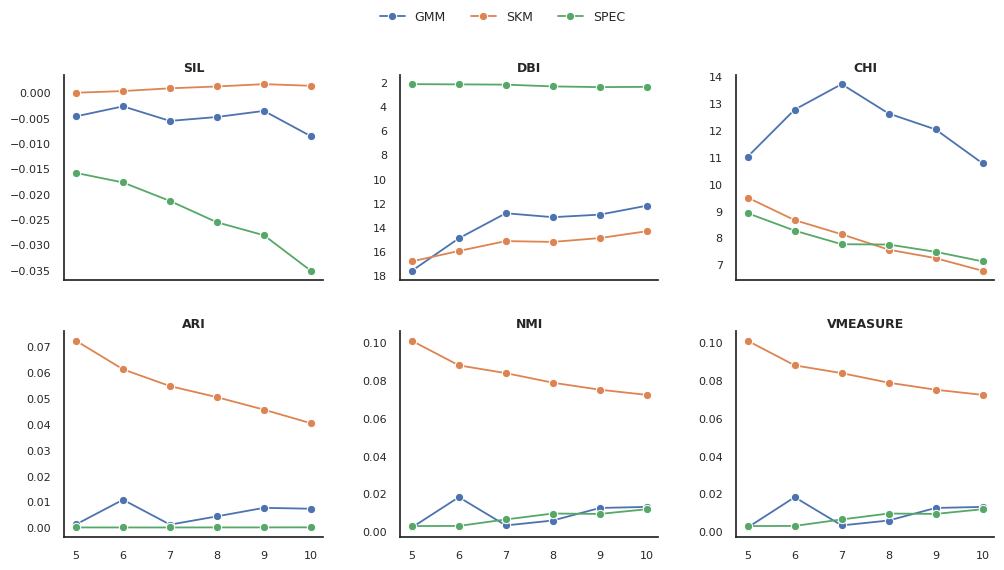

In [87]:
comparison_charts(comparisons)